【第14回_Beginner限定コンペ】健診データによる肝疾患判定

In [1020]:
#必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
#import lightgbm as lgb
import optuna.integration.lightgbm as lgb

import xgboost as xgb
# 一番下でfeature importanceの低い列を探っている
low_feature=[]

### 関数

In [1026]:
# 正常値内（基準値内）判定
def get_in_range(row,r1,r2,col):
    b=(r1<=row[col]) and (row[col]<=r2)
    return b*1

# 正常値の平均からの上下
def calc_range_mean(row,r1,r2,col):
    _mean=(r1+r2)/2
    return row[col]-_mean

# マイナスも対数変換できる
def neg_log(x):
    return np.sign(x) * np.log1p(np.abs(x))

# 特徴量作成と整形
def make_featuredata(df):
    #  削除
    df.drop(columns='id',inplace=True)
    df.drop(columns='Gender',inplace=True)
    
    # 間接ビルビリン
    df['K_Bil']=df['T_Bil']-df['D_Bil']
    # ALT AST比
    df['AL_AS_ratio']=df['ALT_GPT']/df['AST_GOT']
    # グロブリン
    df['Glb']=df['Alb']/df['AG_ratio']
    
    # 間接ビルビリンがマイナスはおかしい
    for index, row in df.iterrows():
        if row['K_Bil']<0:
            #間接ビルビリンがマイナスはおかしい　おそらく逆
            _d=row['D_Bil']
            df.at[index, 'D_Bil'] =row['T_Bil']
            df.at[index, 'T_Bil'] =_d
            df.at[index, 'K_Bil'] =row['T_Bil']-row['D_Bil']
            
    # ビルビリンratio
    #df['bil_ratio']=df['D_Bil']/df['T_Bil']
    
    # 対数変換
    use_col=df.columns.tolist()
    if 'disease' in use_col:# 目的変数はやらない
        use_col.remove('disease')
        
    #交互作用特徴量  
    for c in use_col:
        if 'TP'!=c:
            df[c+'_X_tp'] = df[c]*df['TP']
    for c in use_col:
        if 'T_Bil'!=c:
            df[c+'_X_tBil'] = df[c]*df['T_Bil']
    for c in use_col:
        if 'Alb'!=c:
            df[c+'_X_Alb'] = df[c]*df['Alb']
    for c in use_col:
        if 'Glb'!=c:
            df[c+'_X_Glb'] = df[c]*df['Glb']
    for c in use_col:
        if 'ALT_GPT'!=c:
            df[c+'_X_ALT_GPT'] = df[c]*df['ALT_GPT']
    for c in use_col:
        if 'ALT_GPT'!=c:
            df[c+'_X_ALT_GPT'] = df[c]*df['ALT_GPT']
    for c in use_col:
        if 'Age'!=c:
            df[c+'_X_Age'] = df[c]*df['Age']

    for c in use_col:
        df[c+'_logarithm'] = neg_log(df[c])
        
    # 医療的正常値範囲　平均からどれくらい離れてるか
    for index, row in df.iterrows():
        df.at[index, 'TP_avg']=calc_range_mean(row,6.5,8.2,'TP')
        df.at[index, 'Alb_avg']=calc_range_mean(row,3.9,4.9,'Alb')
        df.at[index, 'TBil_avg']=calc_range_mean(row,0.2,1.2,'T_Bil')
        df.at[index, 'DBil_avg']=calc_range_mean(row,0.3,0.4,'D_Bil')
        df.at[index, 'ALP_avg']=calc_range_mean(row,50,350,'ALP')
        df.at[index, 'AltGpt_avg']=calc_range_mean(row,4,44,'ALT_GPT')
        df.at[index, 'AstGot_avg']=calc_range_mean(row,7,38,'AST_GOT')
    
    # importanceが低かったものは削除
    for c in low_feature:
            df.drop(columns=c,inplace=True)

    return df

### TRAIN DATA

In [1027]:
# サンプルデータ
train_csv_file = 'train.csv'
# 読み込み
df_origin_train = pd.read_csv(train_csv_file,header=0)
# 欠損している行を確認
print(df_origin_train.isnull().sum())
# 欠損している行を削除 上書きの場合は inplace=True
#df_origin.dropna(inplace=True)
print('len=',len(df_origin_train))
# 確認
df_origin_train.head()

id          0
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
dtype: int64
len= 3500


,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0,42,Male,0.786362,0.154075,162.267801,26.053979,37.413395,6.041335,3.584788,0.793957,1
1,1,65,Female,0.939515,0.174262,175.315396,14.346785,11.606569,6.249220,3.499155,0.954351,0
2,2,29,Male,1.221597,0.374223,151.164721,13.226549,11.109054,6.752648,3.498901,1.065019,1
3,3,65,Female,0.889107,0.122545,177.429034,15.376386,15.247101,6.333087,3.440847,0.953817,0
4,4,59,Male,1.990933,0.603734,183.793499,23.202757,54.162685,6.128990,2.560995,0.958612,0


In [1028]:
# 基準値内かどうか
df_temp=df_origin_train.copy()
for index, row in df_temp.iterrows():
    n_tp=get_in_range(row,6.5,8.2,'TP')
    n_alb=get_in_range(row,3.9,4.9,'Alb')
    n_tbl=get_in_range(row,0.2,1.2,'T_Bil')
    n_dbl=get_in_range(row,0.3,0.4,'D_Bil')
    n_alp=get_in_range(row,50,350,'ALP')
    n_alt=get_in_range(row,4,44,'ALT_GPT')
    n_ast=get_in_range(row,7,38,'AST_GOT')
    n_sum=n_tp+n_alb+n_tbl+n_dbl+n_alp+n_alt+n_ast
    #print(n_sum)
    df_temp.at[index, 'in_range'] = n_sum
    df_temp.at[index, 'in_range_per'] = n_sum/7
    
# すべて正常値内なのに疾患な人
df=df_temp[['in_range','disease']]
# 基準値内個数
df_in=df[(6<df['in_range']) & (df['disease']==1) ]
print(df_in)
# 正常値内がほぼ無いのに無疾患な人
df=df_temp[['in_range','disease']]
# 基準値外個数
df_out=df[(df['in_range']<1) & (df['disease']==0) ]
print(df_out)
# 完全イレギュラーな人は削除
df_origin_train.drop(df_in.index,inplace=True)
df_origin_train.drop(df_out.index,inplace=True)
df_origin_train

      in_range  disease
687        7.0        1
1551       7.0        1
1904       7.0        1
2512       7.0        1
2715       7.0        1
2830       7.0        1
3256       7.0        1
      in_range  disease
924        0.0        0
1296       0.0        0
1358       0.0        0
1955       0.0        0
1976       0.0        0
2185       0.0        0


,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0,42,Male,0.786362,0.154075,162.267801,26.053979,37.413395,6.041335,3.584788,0.793957,1
1,1,65,Female,0.939515,0.174262,175.315396,14.346785,11.606569,6.249220,3.499155,0.954351,0
2,2,29,Male,1.221597,0.374223,151.164721,13.226549,11.109054,6.752648,3.498901,1.065019,1
3,3,65,Female,0.889107,0.122545,177.429034,15.376386,15.247101,6.333087,3.440847,0.953817,0
4,4,59,Male,1.990933,0.603734,183.793499,23.202757,54.162685,6.128990,2.560995,0.958612,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3495,3495,48,Female,0.994242,0.181228,169.009071,21.031466,17.132206,7.634777,4.182702,1.021814,1
3496,3496,45,Male,5.328088,2.143938,520.919213,27.401145,38.429709,6.270194,2.516126,0.477743,1
3497,3497,65,Male,0.738559,0.159581,160.299998,23.258722,22.202448,5.173300,2.163873,0.406472,0
3498,3498,59,Male,2.053895,0.231019,289.456787,17.374979,45.803678,3.913332,2.035252,0.392875,0


In [1029]:
# train 特徴量生成
df_pre_train=make_featuredata(df_origin_train)
df_pre_train

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,...,ALP_logarithm,ALT_GPT_logarithm,TP_logarithm,AG_ratio_logarithm,K_Bil_logarithm,AL_AS_ratio_logarithm,Glb_logarithm,TP_avg,DBil_avg,ALP_avg
0,42,0.786362,0.154075,162.267801,26.053979,37.413395,6.041335,3.584788,0.793957,1,...,5.095392,3.297834,1.951798,0.584424,0.489982,0.528497,1.707488,-1.308665,-0.195925,-37.732199
1,65,0.939515,0.174262,175.315396,14.346785,11.606569,6.249220,3.499155,0.954351,0,...,5.172274,2.730906,1.980894,0.670058,0.568294,0.804730,1.540416,-1.100780,-0.175738,-24.684604
2,29,1.221597,0.374223,151.164721,13.226549,11.109054,6.752648,3.498901,1.065019,1,...,5.024964,2.655110,2.048034,0.725139,0.613765,0.784180,1.455189,-0.597352,0.024223,-48.835279
3,65,0.889107,0.122545,177.429034,15.376386,15.247101,6.333087,3.440847,0.953817,0,...,5.184191,2.795840,1.992397,0.669785,0.569035,0.697378,1.527675,-1.016913,-0.227455,-22.570966
4,59,1.990933,0.603734,183.793499,23.202757,54.162685,6.128990,2.560995,0.958612,0,...,5.219239,3.186467,1.964170,0.672236,0.870121,0.356548,1.300618,-1.221010,0.253734,-16.206501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,48,0.994242,0.181228,169.009071,21.031466,17.132206,7.634777,4.182702,1.021814,1,...,5.135852,3.092472,2.155798,0.703995,0.594991,0.800924,1.627947,0.284777,-0.168772,-30.990929
3496,45,5.328088,2.143938,520.919213,27.401145,38.429709,6.270194,2.516126,0.477743,1,...,6.257513,3.346429,1.983783,0.390516,1.431304,0.538258,1.835249,-1.079806,1.793938,320.919213
3497,65,0.738559,0.159581,160.299998,23.258722,22.202448,5.173300,2.163873,0.406472,0,...,5.083266,3.188776,1.820233,0.341084,0.456778,0.716656,1.844281,-2.176700,-0.190419,-39.700002
3498,59,2.053895,0.231019,289.456787,17.374979,45.803678,3.913332,2.035252,0.392875,0,...,5.671455,2.910990,1.591952,0.331370,1.037756,0.321602,1.821385,-3.436668,-0.118981,89.456787


In [1030]:
# 相関係数
corr_matrix = df_pre_train.corr()
# 目的変数との相関係数だけ抽出
corr_y = pd.DataFrame({"features":df_pre_train.columns,"corr_y":corr_matrix["disease"]},index=None)
# 見るとき
corr_y = corr_y.reset_index(drop=True)
corr_y.style.background_gradient()

,features,corr_y
0,Age,-0.089097
1,T_Bil,0.353622
2,D_Bil,0.323286
3,ALP,0.218759
4,ALT_GPT,0.201668
5,AST_GOT,0.309705
6,TP,-0.157830
7,Alb,-0.274378
8,AG_ratio,-0.268018
9,disease,1.000000


In [1031]:
## 相関係数でフィルタ 相関係数の絶対値をとって、閾値と比較する
select_cols = corr_y[corr_y["corr_y"].abs()>0.1]
select_cols = list(select_cols["features"])
print(select_cols)
print('フィルタ後',len(select_cols),'/',len(df_pre_train.columns))
#特徴選択後のデータ
df_feat_train = df_pre_train.loc[:,select_cols]
df_feat_train

['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb', 'AG_ratio', 'disease', 'K_Bil', 'AL_AS_ratio', 'Glb', 'Age_X_tp', 'T_Bil_X_tp', 'D_Bil_X_tp', 'ALP_X_tp', 'ALT_GPT_X_tp', 'AST_GOT_X_tp', 'Alb_X_tp', 'AG_ratio_X_tp', 'K_Bil_X_tp', 'Age_X_tBil', 'D_Bil_X_tBil', 'ALP_X_tBil', 'ALT_GPT_X_tBil', 'AST_GOT_X_tBil', 'Alb_X_tBil', 'AG_ratio_X_tBil', 'K_Bil_X_tBil', 'AL_AS_ratio_X_tBil', 'Glb_X_tBil', 'Age_X_Alb', 'D_Bil_X_Alb', 'ALP_X_Alb', 'ALT_GPT_X_Alb', 'AST_GOT_X_Alb', 'AG_ratio_X_Alb', 'K_Bil_X_Alb', 'D_Bil_X_Glb', 'ALP_X_Glb', 'ALT_GPT_X_Glb', 'AST_GOT_X_Glb', 'AG_ratio_X_Glb', 'K_Bil_X_Glb', 'AL_AS_ratio_X_Glb', 'Age_X_ALT_GPT', 'T_Bil_X_ALT_GPT', 'D_Bil_X_ALT_GPT', 'ALP_X_ALT_GPT', 'AST_GOT_X_ALT_GPT', 'AG_ratio_X_ALT_GPT', 'K_Bil_X_ALT_GPT', 'AL_AS_ratio_X_ALT_GPT', 'T_Bil_X_Age', 'D_Bil_X_Age', 'ALP_X_Age', 'ALT_GPT_X_Age', 'AST_GOT_X_Age', 'TP_X_Age', 'Alb_X_Age', 'AG_ratio_X_Age', 'K_Bil_X_Age', 'T_Bil_logarithm', 'ALP_logarithm', 'ALT_GPT_logarithm', 'TP_logarithm', 'A

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,K_Bil,...,T_Bil_logarithm,ALP_logarithm,ALT_GPT_logarithm,TP_logarithm,AG_ratio_logarithm,K_Bil_logarithm,Glb_logarithm,TP_avg,DBil_avg,ALP_avg
0,0.786362,0.154075,162.267801,26.053979,37.413395,6.041335,3.584788,0.793957,1,0.632287,...,0.580181,5.095392,3.297834,1.951798,0.584424,0.489982,1.707488,-1.308665,-0.195925,-37.732199
1,0.939515,0.174262,175.315396,14.346785,11.606569,6.249220,3.499155,0.954351,0,0.765252,...,0.662438,5.172274,2.730906,1.980894,0.670058,0.568294,1.540416,-1.100780,-0.175738,-24.684604
2,1.221597,0.374223,151.164721,13.226549,11.109054,6.752648,3.498901,1.065019,1,0.847375,...,0.798226,5.024964,2.655110,2.048034,0.725139,0.613765,1.455189,-0.597352,0.024223,-48.835279
3,0.889107,0.122545,177.429034,15.376386,15.247101,6.333087,3.440847,0.953817,0,0.766561,...,0.636104,5.184191,2.795840,1.992397,0.669785,0.569035,1.527675,-1.016913,-0.227455,-22.570966
4,1.990933,0.603734,183.793499,23.202757,54.162685,6.128990,2.560995,0.958612,0,1.387199,...,1.095585,5.219239,3.186467,1.964170,0.672236,0.870121,1.300618,-1.221010,0.253734,-16.206501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.994242,0.181228,169.009071,21.031466,17.132206,7.634777,4.182702,1.021814,1,0.813014,...,0.690264,5.135852,3.092472,2.155798,0.703995,0.594991,1.627947,0.284777,-0.168772,-30.990929
3496,5.328088,2.143938,520.919213,27.401145,38.429709,6.270194,2.516126,0.477743,1,3.184150,...,1.844998,6.257513,3.346429,1.983783,0.390516,1.431304,1.835249,-1.079806,1.793938,320.919213
3497,0.738559,0.159581,160.299998,23.258722,22.202448,5.173300,2.163873,0.406472,0,0.578978,...,0.553057,5.083266,3.188776,1.820233,0.341084,0.456778,1.844281,-2.176700,-0.190419,-39.700002
3498,2.053895,0.231019,289.456787,17.374979,45.803678,3.913332,2.035252,0.392875,0,1.822876,...,1.116418,5.671455,2.910990,1.591952,0.331370,1.037756,1.821385,-3.436668,-0.118981,89.456787


In [1032]:
# 欠損している行を確認
pd.set_option('display.max_rows', 200)
print(df_feat_train.isnull().sum())

T_Bil                    0
D_Bil                    0
ALP                      0
ALT_GPT                  0
AST_GOT                  0
TP                       0
Alb                      0
AG_ratio                 0
disease                  0
K_Bil                    0
AL_AS_ratio              0
Glb                      0
Age_X_tp                 0
T_Bil_X_tp               0
D_Bil_X_tp               0
ALP_X_tp                 0
ALT_GPT_X_tp             0
AST_GOT_X_tp             0
Alb_X_tp                 0
AG_ratio_X_tp            0
K_Bil_X_tp               0
Age_X_tBil               0
D_Bil_X_tBil             0
ALP_X_tBil               0
ALT_GPT_X_tBil           0
AST_GOT_X_tBil           0
Alb_X_tBil               0
AG_ratio_X_tBil          0
K_Bil_X_tBil             0
AL_AS_ratio_X_tBil       0
Glb_X_tBil               0
Age_X_Alb                0
D_Bil_X_Alb              0
ALP_X_Alb                0
ALT_GPT_X_Alb            0
AST_GOT_X_Alb            0
AG_ratio_X_Alb           0
K

In [1033]:
# 目的変数
df_trainY=df_origin_train['disease']
df_trainY.to_csv('y_train.csv')
df_trainY

0       1
1       0
2       1
3       0
4       0
       ..
3495    1
3496    1
3497    0
3498    0
3499    1
Name: disease, Length: 3487, dtype: int64

In [1034]:
# 目的変数(ラベル列) 削除
df_feat_train.drop(columns='disease',inplace=True)
df_feat_train.to_csv('edited_train.csv')
df_feat_train.reset_index(inplace=True, drop=True)

### TEST DATA (submit)

In [1035]:
# サンプルデータ
test_csv_file = 'test.csv'
# 読み込み
df_origin_test = pd.read_csv(test_csv_file,header=0)
print('len=',len(df_origin_test))
# 確認
df_origin_test.head()

len= 1500


,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,3500,21,Male,1.748247,0.782181,172.009688,19.968145,25.511490,4.994592,3.531170,0.701090
1,3501,58,Male,0.823942,0.186251,563.429687,22.582610,123.615857,5.280352,2.158567,0.398693
2,3502,29,Male,1.063258,0.279337,235.621148,14.077811,21.181787,6.935953,3.594940,0.526508
3,3503,41,Male,4.126134,2.536933,517.952123,28.786567,37.396628,6.998487,2.981257,0.492407
4,3504,21,Male,0.971008,0.200773,176.657398,16.852271,19.791978,6.041369,3.615450,1.006647


In [1036]:
# test 特徴量生成
df_pre_test=make_featuredata(df_origin_test)
#特徴選択後のデータ
select_cols.remove('disease')# 含んでないので
df_pre_test = df_pre_test.loc[:,select_cols]
df_pre_test.to_csv('edited_test.csv')
df_pre_test

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,K_Bil,AL_AS_ratio,...,T_Bil_logarithm,ALP_logarithm,ALT_GPT_logarithm,TP_logarithm,AG_ratio_logarithm,K_Bil_logarithm,Glb_logarithm,TP_avg,DBil_avg,ALP_avg
0,1.748247,0.782181,172.009688,19.968145,25.511490,4.994592,3.531170,0.701090,0.966066,0.782712,...,1.010963,5.153348,3.043004,1.790858,0.531269,0.676035,1.797855,-2.355408,0.432181,-27.990312
1,0.823942,0.186251,563.429687,22.582610,123.615857,5.280352,2.158567,0.398693,0.637691,0.182684,...,0.601000,6.335816,3.160510,1.837426,0.335538,0.493287,1.858500,-2.069648,-0.163749,363.429687
2,1.063258,0.279337,235.621148,14.077811,21.181787,6.935953,3.594940,0.526508,0.783922,0.664619,...,0.724286,5.466460,2.713224,2.071403,0.422983,0.578814,2.057693,-0.414047,-0.070663,35.621148
3,4.126134,2.536933,517.952123,28.786567,37.396628,6.998487,2.981257,0.492407,1.589201,0.769764,...,1.634352,6.251812,3.394058,2.079252,0.400390,0.951349,1.953659,-0.351513,2.186933,317.952123
4,0.971008,0.200773,176.657398,16.852271,19.791978,6.041369,3.615450,1.006647,0.770235,0.851470,...,0.678545,5.179857,2.882131,1.951803,0.696465,0.571113,1.524224,-1.308631,-0.149227,-23.342602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.930171,0.255303,199.291369,21.996095,17.360947,4.980917,3.042486,0.999639,0.674868,1.266987,...,0.657608,5.299773,3.135324,1.788574,0.692967,0.515734,1.397132,-2.369083,-0.094697,-0.708631
1496,0.964929,0.194533,171.453908,17.161291,17.214381,7.651131,3.984259,0.979076,0.770395,0.996916,...,0.675456,5.150130,2.899292,2.157690,0.682630,0.571203,1.623224,0.301131,-0.155467,-28.546092
1497,4.517463,2.002478,147.654182,62.854587,49.240915,6.064626,3.524967,1.121895,2.514985,1.276471,...,1.707918,5.001623,4.156608,1.955100,0.752310,1.257035,1.421173,-1.285374,1.652478,-52.345818
1498,1.780137,0.600853,175.589200,25.807945,46.454176,6.079286,3.668198,0.713654,1.179284,0.555557,...,1.022500,5.173826,3.288698,1.957173,0.538628,0.778996,1.814828,-1.270714,0.250853,-24.410800


## XGBoost
scoreを特徴量に加える

In [1037]:
FOLD=10
# fold CVモデルの学習
# FOLDのモデルを保存するリストの初期化
models = []
auc_list=[]
df_evalScore=pd.DataFrame(index=range(len(df_trainY)),columns=['score'])

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(df_trainY)))
# KFoldクラスをインスタンス化
K_fold = StratifiedKFold(n_splits=FOLD, shuffle=True,  random_state=1010)

# KFoldクラスで分割した回数だけ実行
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, df_trainY):
    # ilocで取り出す行を指定
    X_train_cv = df_feat_train.iloc[train_cv_no, :]
    X_eval_cv = df_feat_train.iloc[eval_cv_no, :]
    y_train_cv = pd.Series(df_trainY).iloc[train_cv_no]
    y_eval_cv = pd.Series(df_trainY).iloc[eval_cv_no]
    
    # XGBoost が扱うデータセットの形式に直す
    xgb_trainSet = xgb.DMatrix(X_train_cv, label=y_train_cv)
    xgb_evalSet = xgb.DMatrix(X_eval_cv, label=y_eval_cv)
    # 学習用のパラメータ
    xgb_params = {
        # 二値分類問題
        'objective': 'binary:logistic',
        # 評価指標
        'eval_metric': 'auc',
    }
    xgb.set_config(verbosity=0)
    # モデルを学習する early stopping?
    bst = xgb.train(params =xgb_params,
                    dtrain =xgb_trainSet,
                    evals = [(xgb_trainSet, "train"), (xgb_evalSet, "eval")],
                    num_boost_round=1000,  # 学習ラウンド数は適当
                    early_stopping_rounds=10
                    )
    
    # 評価する
    y_pred = bst.predict(xgb_evalSet,ntree_limit=bst.best_ntree_limit)
    # XGBoostの予測スコアをあとで特徴量に
    for idx,m in enumerate(eval_cv_no):
        df_evalScore.iloc[m,0]=y_pred[idx]
    
    # AUC (Area Under the Curve) を計算する
    fpr, tpr, thresholds = metrics.roc_curve(y_eval_cv, y_pred)
    auc = metrics.auc(fpr, tpr)
    print('auc',auc)
    auc_list.append(auc)

    # 学習が終わったモデルをリストに入れておく
    models.append(bst) 
print('auc avarage ',np.mean(auc_list))

# ubuntu desktopなので通知できる　時間かかるので
!notify-send -u critical "train" "完了"
#
print('eval score df isnull sum = ',df_evalScore.isnull().sum())
df_evalScore

[0]	train-auc:0.91735	eval-auc:0.88757
[1]	train-auc:0.93907	eval-auc:0.89619
[2]	train-auc:0.94943	eval-auc:0.90357
[3]	train-auc:0.95979	eval-auc:0.90132
[4]	train-auc:0.96614	eval-auc:0.90249
[5]	train-auc:0.97067	eval-auc:0.90906
[6]	train-auc:0.97499	eval-auc:0.90825
[7]	train-auc:0.97829	eval-auc:0.90820
[8]	train-auc:0.98119	eval-auc:0.90510
[9]	train-auc:0.98263	eval-auc:0.90737
[10]	train-auc:0.98422	eval-auc:0.90789
[11]	train-auc:0.98728	eval-auc:0.90823
[12]	train-auc:0.98832	eval-auc:0.90887
[13]	train-auc:0.98960	eval-auc:0.90881
[14]	train-auc:0.99055	eval-auc:0.90881
auc 0.9090616531165312
[0]	train-auc:0.92291	eval-auc:0.88970
[1]	train-auc:0.94245	eval-auc:0.89465
[2]	train-auc:0.95084	eval-auc:0.89568
[3]	train-auc:0.95752	eval-auc:0.89489
[4]	train-auc:0.96396	eval-auc:0.89865
[5]	train-auc:0.96932	eval-auc:0.89517


/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	train-auc:0.97406	eval-auc:0.90092
[7]	train-auc:0.97666	eval-auc:0.90186
[8]	train-auc:0.97899	eval-auc:0.90396
[9]	train-auc:0.98025	eval-auc:0.90522
[10]	train-auc:0.98168	eval-auc:0.90532
[11]	train-auc:0.98476	eval-auc:0.90417
[12]	train-auc:0.98686	eval-auc:0.90241
[13]	train-auc:0.98788	eval-auc:0.90312
[14]	train-auc:0.98896	eval-auc:0.90383
[15]	train-auc:0.99054	eval-auc:0.90557
[16]	train-auc:0.99241	eval-auc:0.90679
[17]	train-auc:0.99343	eval-auc:0.90566
[18]	train-auc:0.99469	eval-auc:0.90576
[19]	train-auc:0.99496	eval-auc:0.90671
[20]	train-auc:0.99553	eval-auc:0.90749
[21]	train-auc:0.99628	eval-auc:0.90593
[22]	train-auc:0.99669	eval-auc:0.90867
[23]	train-auc:0.99698	eval-auc:0.90884
[24]	train-auc:0.99736	eval-auc:0.90745
[25]	train-auc:0.99757	eval-auc:0.90786
[26]	train-auc:0.99821	eval-auc:0.90915
[27]	train-auc:0.99845	eval-auc:0.91033
[28]	train-auc:0.99852	eval-auc:0.90972
[29]	train-auc:0.99875	eval-auc:0.90938
[30]	train-auc:0.99896	eval-auc:0.90918
[31]

/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	train-auc:0.97447	eval-auc:0.90381
[7]	train-auc:0.97759	eval-auc:0.90395
[8]	train-auc:0.98004	eval-auc:0.90882
[9]	train-auc:0.98227	eval-auc:0.91191
[10]	train-auc:0.98442	eval-auc:0.91252
[11]	train-auc:0.98769	eval-auc:0.91162
[12]	train-auc:0.98856	eval-auc:0.91328
[13]	train-auc:0.98909	eval-auc:0.91321
[14]	train-auc:0.99039	eval-auc:0.91369
[15]	train-auc:0.99115	eval-auc:0.91443
[16]	train-auc:0.99199	eval-auc:0.91551
[17]	train-auc:0.99323	eval-auc:0.91602
[18]	train-auc:0.99433	eval-auc:0.91633
[19]	train-auc:0.99476	eval-auc:0.91582
[20]	train-auc:0.99508	eval-auc:0.91619
[21]	train-auc:0.99521	eval-auc:0.91680
[22]	train-auc:0.99570	eval-auc:0.91643
[23]	train-auc:0.99614	eval-auc:0.91660
[24]	train-auc:0.99642	eval-auc:0.91504
[25]	train-auc:0.99687	eval-auc:0.91687
[26]	train-auc:0.99703	eval-auc:0.91755
[27]	train-auc:0.99754	eval-auc:0.91694
[28]	train-auc:0.99777	eval-auc:0.91700
[29]	train-auc:0.99786	eval-auc:0.91745
[30]	train-auc:0.99841	eval-auc:0.91741
[31]

/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	train-auc:0.97496	eval-auc:0.89509
[7]	train-auc:0.97833	eval-auc:0.90125
[8]	train-auc:0.98122	eval-auc:0.90300
[9]	train-auc:0.98283	eval-auc:0.90534
[10]	train-auc:0.98580	eval-auc:0.90898
[11]	train-auc:0.98752	eval-auc:0.91402
[12]	train-auc:0.98823	eval-auc:0.91450
[13]	train-auc:0.98916	eval-auc:0.91369
[14]	train-auc:0.99074	eval-auc:0.91470
[15]	train-auc:0.99178	eval-auc:0.91467
[16]	train-auc:0.99238	eval-auc:0.91467
[17]	train-auc:0.99298	eval-auc:0.91372
[18]	train-auc:0.99361	eval-auc:0.91341
[19]	train-auc:0.99458	eval-auc:0.91423
[20]	train-auc:0.99511	eval-auc:0.91406
[21]	train-auc:0.99604	eval-auc:0.91179
[22]	train-auc:0.99646	eval-auc:0.91175
[23]	train-auc:0.99694	eval-auc:0.91118
auc 0.9147018970189701
[0]	train-auc:0.92464	eval-auc:0.85003
[1]	train-auc:0.94567	eval-auc:0.87178
[2]	train-auc:0.95428	eval-auc:0.87527
[3]	train-auc:0.96074	eval-auc:0.87674
[4]	train-auc:0.96768	eval-auc:0.87759
[5]	train-auc:0.97219	eval-auc:0.88181


/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[6]	train-auc:0.97573	eval-auc:0.88709
[7]	train-auc:0.97920	eval-auc:0.89041
[8]	train-auc:0.98124	eval-auc:0.89397
[9]	train-auc:0.98257	eval-auc:0.89560
[10]	train-auc:0.98434	eval-auc:0.89914
[11]	train-auc:0.98562	eval-auc:0.89821
[12]	train-auc:0.98750	eval-auc:0.89783
[13]	train-auc:0.98818	eval-auc:0.89726
[14]	train-auc:0.98861	eval-auc:0.89658
[15]	train-auc:0.98969	eval-auc:0.89607
[16]	train-auc:0.99008	eval-auc:0.89888
[17]	train-auc:0.99146	eval-auc:0.90213
[18]	train-auc:0.99264	eval-auc:0.90244
[19]	train-auc:0.99314	eval-auc:0.90149
[20]	train-auc:0.99343	eval-auc:0.90122
[21]	train-auc:0.99369	eval-auc:0.90092
[22]	train-auc:0.99406	eval-auc:0.90102
[23]	train-auc:0.99464	eval-auc:0.90234
[24]	train-auc:0.99588	eval-auc:0.90064
[25]	train-auc:0.99650	eval-auc:0.90081
[26]	train-auc:0.99731	eval-auc:0.90146
[27]	train-auc:0.99761	eval-auc:0.89993
[28]	train-auc:0.99832	eval-auc:0.89895
auc 0.9024390243902439
[0]	train-auc:0.92094	eval-auc:0.88484
[1]	train-auc:0.94023	

/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	train-auc:0.96363	eval-auc:0.91831
[5]	train-auc:0.96848	eval-auc:0.92583
[6]	train-auc:0.97181	eval-auc:0.92381
[7]	train-auc:0.97541	eval-auc:0.92480
[8]	train-auc:0.97715	eval-auc:0.92356
[9]	train-auc:0.98062	eval-auc:0.92788
[10]	train-auc:0.98235	eval-auc:0.92876
[11]	train-auc:0.98370	eval-auc:0.92835
[12]	train-auc:0.98575	eval-auc:0.92663
[13]	train-auc:0.98701	eval-auc:0.92761
[14]	train-auc:0.98772	eval-auc:0.92815
[15]	train-auc:0.98882	eval-auc:0.92995
[16]	train-auc:0.99106	eval-auc:0.93134
[17]	train-auc:0.99162	eval-auc:0.93096
[18]	train-auc:0.99220	eval-auc:0.93059
[19]	train-auc:0.99294	eval-auc:0.92981
[20]	train-auc:0.99382	eval-auc:0.93140
[21]	train-auc:0.99450	eval-auc:0.93174
[22]	train-auc:0.99488	eval-auc:0.93330
[23]	train-auc:0.99549	eval-auc:0.93337
[24]	train-auc:0.99575	eval-auc:0.93371
[25]	train-auc:0.99590	eval-auc:0.93330
[26]	train-auc:0.99682	eval-auc:0.93381
[27]	train-auc:0.99750	eval-auc:0.93344
[28]	train-auc:0.99834	eval-auc:0.93421
[29]	t

/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	train-auc:0.96729	eval-auc:0.90556
[5]	train-auc:0.96975	eval-auc:0.90171
[6]	train-auc:0.97265	eval-auc:0.90329
[7]	train-auc:0.97620	eval-auc:0.90669
[8]	train-auc:0.97769	eval-auc:0.90446
[9]	train-auc:0.98063	eval-auc:0.90681
[10]	train-auc:0.98351	eval-auc:0.90440
[11]	train-auc:0.98506	eval-auc:0.90447
[12]	train-auc:0.98690	eval-auc:0.90623
[13]	train-auc:0.98768	eval-auc:0.90603
[14]	train-auc:0.98914	eval-auc:0.90661
[15]	train-auc:0.99049	eval-auc:0.90688
[16]	train-auc:0.99146	eval-auc:0.90782
[17]	train-auc:0.99250	eval-auc:0.90799
[18]	train-auc:0.99398	eval-auc:0.90738
[19]	train-auc:0.99472	eval-auc:0.90667
[20]	train-auc:0.99548	eval-auc:0.90657
[21]	train-auc:0.99647	eval-auc:0.90698
[22]	train-auc:0.99683	eval-auc:0.90681
[23]	train-auc:0.99732	eval-auc:0.90684
[24]	train-auc:0.99762	eval-auc:0.90694
[25]	train-auc:0.99801	eval-auc:0.90827
[26]	train-auc:0.99824	eval-auc:0.90884
[27]	train-auc:0.99851	eval-auc:0.90881
[28]	train-auc:0.99882	eval-auc:0.90816
[29]	t

/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	train-auc:0.97205	eval-auc:0.87653
[6]	train-auc:0.97629	eval-auc:0.88252
[7]	train-auc:0.97906	eval-auc:0.88445
[8]	train-auc:0.98182	eval-auc:0.88697
[9]	train-auc:0.98355	eval-auc:0.89258
[10]	train-auc:0.98529	eval-auc:0.89313
[11]	train-auc:0.98710	eval-auc:0.89149
[12]	train-auc:0.98917	eval-auc:0.89389
[13]	train-auc:0.98992	eval-auc:0.89505
[14]	train-auc:0.99044	eval-auc:0.89406
[15]	train-auc:0.99147	eval-auc:0.89396
[16]	train-auc:0.99262	eval-auc:0.89662
[17]	train-auc:0.99337	eval-auc:0.89624
[18]	train-auc:0.99437	eval-auc:0.89719
[19]	train-auc:0.99510	eval-auc:0.89764
[20]	train-auc:0.99561	eval-auc:0.89866
[21]	train-auc:0.99611	eval-auc:0.89764
[22]	train-auc:0.99650	eval-auc:0.89665
[23]	train-auc:0.99674	eval-auc:0.89580
[24]	train-auc:0.99746	eval-auc:0.89560
[25]	train-auc:0.99775	eval-auc:0.89668
[26]	train-auc:0.99796	eval-auc:0.89662
[27]	train-auc:0.99808	eval-auc:0.89679
[28]	train-auc:0.99848	eval-auc:0.89580
[29]	train-auc:0.99853	eval-auc:0.89689
[30]	

/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[5]	train-auc:0.96951	eval-auc:0.93393
[6]	train-auc:0.97371	eval-auc:0.93372
[7]	train-auc:0.97665	eval-auc:0.93529
[8]	train-auc:0.97918	eval-auc:0.93319
[9]	train-auc:0.98133	eval-auc:0.93588
[10]	train-auc:0.98297	eval-auc:0.93643
[11]	train-auc:0.98451	eval-auc:0.93752
[12]	train-auc:0.98759	eval-auc:0.93953
[13]	train-auc:0.98829	eval-auc:0.94143
[14]	train-auc:0.98939	eval-auc:0.94153
[15]	train-auc:0.98979	eval-auc:0.94112
[16]	train-auc:0.99105	eval-auc:0.93980
[17]	train-auc:0.99158	eval-auc:0.93980
[18]	train-auc:0.99251	eval-auc:0.93987
[19]	train-auc:0.99325	eval-auc:0.94112
[20]	train-auc:0.99328	eval-auc:0.94107
[21]	train-auc:0.99398	eval-auc:0.94210
[22]	train-auc:0.99459	eval-auc:0.94281
[23]	train-auc:0.99512	eval-auc:0.94145
[24]	train-auc:0.99560	eval-auc:0.94254
[25]	train-auc:0.99648	eval-auc:0.94247
[26]	train-auc:0.99672	eval-auc:0.94203
[27]	train-auc:0.99677	eval-auc:0.94131
[28]	train-auc:0.99714	eval-auc:0.94135
[29]	train-auc:0.99736	eval-auc:0.94138
[30]	

/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


[4]	train-auc:0.96965	eval-auc:0.89599
[5]	train-auc:0.97404	eval-auc:0.90147
[6]	train-auc:0.97727	eval-auc:0.90067
[7]	train-auc:0.97987	eval-auc:0.90420
[8]	train-auc:0.98262	eval-auc:0.90484
[9]	train-auc:0.98477	eval-auc:0.90698
[10]	train-auc:0.98559	eval-auc:0.90916
[11]	train-auc:0.98609	eval-auc:0.90919
[12]	train-auc:0.98708	eval-auc:0.90970
[13]	train-auc:0.98824	eval-auc:0.91144
[14]	train-auc:0.98928	eval-auc:0.91196
[15]	train-auc:0.98984	eval-auc:0.91192
[16]	train-auc:0.99055	eval-auc:0.91161
[17]	train-auc:0.99211	eval-auc:0.91380
[18]	train-auc:0.99340	eval-auc:0.91305
[19]	train-auc:0.99408	eval-auc:0.91209
[20]	train-auc:0.99455	eval-auc:0.91213
[21]	train-auc:0.99570	eval-auc:0.91353
[22]	train-auc:0.99601	eval-auc:0.91428
[23]	train-auc:0.99671	eval-auc:0.91489
[24]	train-auc:0.99747	eval-auc:0.91486
[25]	train-auc:0.99767	eval-auc:0.91530
[26]	train-auc:0.99784	eval-auc:0.91612
[27]	train-auc:0.99796	eval-auc:0.91544
[28]	train-auc:0.99818	eval-auc:0.91568
[29]	t

/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


eval score df isnull sum =  score    0
dtype: int64


,score
0,0.276007
1,0.0645913
2,0.884374
3,0.170844
4,0.552969
...,...
3482,0.900008
3483,0.969366
3484,0.275724
3485,0.706887


In [1038]:
# XGBoostのスコアを新たな特徴量とする
df_concat_feat_train = pd.concat([df_feat_train, df_evalScore], axis=1)
# なぜかscoreがtype=objectになったのでキャスト
df_concat_feat_train=df_concat_feat_train.astype({'score': float})

In [1039]:
# XGBoost TEST
df_test_pred = pd.DataFrame()
# FOLD個のモデル
for fold_, model in enumerate(models):
    # testを予測
    test_predicted = model.predict(xgb.DMatrix(df_pre_test),ntree_limit=model.best_ntree_limit)
    # testの予測をdataframeに保存
    test_predicted=test_predicted.reshape([-1,1])
    test_predicted=test_predicted.reshape(-1)
    print(test_predicted)
    df_test_pred[fold_ ]=test_predicted
                 
# 各モデルが出した確率を平均する
pred_mean=df_test_pred.mean(axis='columns')
# testも新たな特徴量とする
df_tes_score=pd.DataFrame(pred_mean,columns=['score'])
df_concat_feat_test = pd.concat([df_pre_test,df_tes_score ], axis=1)
df_concat_feat_test

[0.5751868  0.73345816 0.8599518  ... 0.6413499  0.52904767 0.80260277]
[0.6085945  0.84585714 0.9755492  ... 0.9708066  0.27883586 0.7974878 ]
[0.6842482  0.9399352  0.93202716 ... 0.8142642  0.5225337  0.7550989 ]
[0.5698363  0.7421097  0.8722798  ... 0.6076763  0.4595757  0.75861454]
[0.6824405  0.75063086 0.8891312  ... 0.9050871  0.6615861  0.80585176]
[0.7209182  0.93108153 0.9346935  ... 0.79939    0.26896486 0.82121694]
[0.7750121  0.95690095 0.98084533 ... 0.7371957  0.16626215 0.8602644 ]
[0.7363251  0.7874428  0.96619207 ... 0.67894334 0.52680254 0.8727493 ]
[0.6383837  0.8322631  0.91780066 ... 0.5343153  0.5383503  0.72021335]
[0.6465259  0.9310398  0.9513251  ... 0.9403063  0.3470429  0.79354495]


/home/koji/anaconda3/lib/python3.7/site-packages/xgboost/core.py:104: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning


,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,K_Bil,AL_AS_ratio,...,ALP_logarithm,ALT_GPT_logarithm,TP_logarithm,AG_ratio_logarithm,K_Bil_logarithm,Glb_logarithm,TP_avg,DBil_avg,ALP_avg,score
0,1.748247,0.782181,172.009688,19.968145,25.511490,4.994592,3.531170,0.701090,0.966066,0.782712,...,5.153348,3.043004,1.790858,0.531269,0.676035,1.797855,-2.355408,0.432181,-27.990312,0.663747
1,0.823942,0.186251,563.429687,22.582610,123.615857,5.280352,2.158567,0.398693,0.637691,0.182684,...,6.335816,3.160510,1.837426,0.335538,0.493287,1.858500,-2.069648,-0.163749,363.429687,0.845072
2,1.063258,0.279337,235.621148,14.077811,21.181787,6.935953,3.594940,0.526508,0.783922,0.664619,...,5.466460,2.713224,2.071403,0.422983,0.578814,2.057693,-0.414047,-0.070663,35.621148,0.927980
3,4.126134,2.536933,517.952123,28.786567,37.396628,6.998487,2.981257,0.492407,1.589201,0.769764,...,6.251812,3.394058,2.079252,0.400390,0.951349,1.953659,-0.351513,2.186933,317.952123,0.972372
4,0.971008,0.200773,176.657398,16.852271,19.791978,6.041369,3.615450,1.006647,0.770235,0.851470,...,5.179857,2.882131,1.951803,0.696465,0.571113,1.524224,-1.308631,-0.149227,-23.342602,0.669348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.930171,0.255303,199.291369,21.996095,17.360947,4.980917,3.042486,0.999639,0.674868,1.266987,...,5.299773,3.135324,1.788574,0.692967,0.515734,1.397132,-2.369083,-0.094697,-0.708631,0.572800
1496,0.964929,0.194533,171.453908,17.161291,17.214381,7.651131,3.984259,0.979076,0.770395,0.996916,...,5.150130,2.899292,2.157690,0.682630,0.571203,1.623224,0.301131,-0.155467,-28.546092,0.320244
1497,4.517463,2.002478,147.654182,62.854587,49.240915,6.064626,3.524967,1.121895,2.514985,1.276471,...,5.001623,4.156608,1.955100,0.752310,1.257035,1.421173,-1.285374,1.652478,-52.345818,0.762933
1498,1.780137,0.600853,175.589200,25.807945,46.454176,6.079286,3.668198,0.713654,1.179284,0.555557,...,5.173826,3.288698,1.957173,0.538628,0.778996,1.814828,-1.270714,0.250853,-24.410800,0.429900


## LightGBM Hyperparameter tuning

In [1040]:
# クロスバリデーションによるハイパーパラメータの探索  fold

lgb_tuner_params = {'objective':'binary', 
              'metric':'auc', 
              'random_seed':1010,
              'verbosity': -1}

lgb_tuner_trainSet = lgb.Dataset(df_concat_feat_train, df_trainY)

FOLD=10
# KFoldクラスをインスタンス化
K_fold = StratifiedKFold(n_splits=FOLD, shuffle=True,  random_state=1010)

tuner = lgb.LightGBMTunerCV(lgb_tuner_params,
                            lgb_tuner_trainSet, 
                            num_boost_round=100,
                            verbose_eval=-1, 
                            verbosity=-1,
                            show_progress_bar=False,
                            early_stopping_rounds=100, 
                            folds=K_fold,
                            seed =1010)

# ハイパーパラメータ探索の実行
tuner.run()

# サーチしたパラメータの表示
print( 'Best score = ',tuner.best_score)
best_params = tuner.best_params
print('Params: ')
for key, value in best_params.items():
    print('  {}: {}'.format(key, value))
    
    
# ubuntu desktopなので通知できる　時間かかるので
!notify-send -u critical "ハイパーパラメータ探索" "完了"

/home/koji/anaconda3/lib/python3.7/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:445: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  FutureWarning,


Best score =  0.9177560833707712
Params: 
  objective: binary
  metric: auc
  random_seed: 1010
  verbosity: -1
  feature_pre_filter: False
  lambda_l1: 0.0
  lambda_l2: 0.0
  num_leaves: 98
  feature_fraction: 0.5
  bagging_fraction: 0.6975762947111845
  bagging_freq: 6
  min_child_samples: 20


## LightGBM 　Train/Evaluate

In [1041]:
# fold CVモデルの学習
# FOLDのモデルを保存するリストの初期化
models = []
auc_list=[]

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(df_trainY)))
# KFoldクラスをインスタンス化
K_fold = StratifiedKFold(n_splits=FOLD, shuffle=True,  random_state=1010)

# KFoldクラスで分割した回数だけ実行
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, df_trainY):
    # ilocで取り出す行を指定
    X_train_cv = df_concat_feat_train.iloc[train_cv_no, :]
    X_eval_cv = df_concat_feat_train.iloc[eval_cv_no, :]
    y_train_cv = pd.Series(df_trainY).iloc[train_cv_no]
    y_eval_cv = pd.Series(df_trainY).iloc[eval_cv_no]
    
    lgb_trainSet = lgb.Dataset(X_train_cv, y_train_cv)
    lgb_evalSet = lgb.Dataset(X_eval_cv, y_eval_cv,reference=lgb_trainSet)#検証用のデータセットである場合は、トレーニングデータをreferenceする。
    lgb_results = {} 
    gbm = lgb.train( tuner.best_params,
                train_set=lgb_trainSet, 
                valid_sets=[lgb_trainSet,lgb_evalSet],
                early_stopping_rounds=100, 
                num_boost_round=100,
                valid_names=['train', 'eval'],
                evals_result=lgb_results,
                verbose_eval=False
               )
    
    # 評価する
    y_pred = gbm.predict(X_eval_cv, num_iteration=gbm.best_iteration)
    # AUC (Area Under the Curve) を計算する
    fpr, tpr, thresholds = metrics.roc_curve(y_eval_cv, y_pred)
    auc = metrics.auc(fpr, tpr)
    print('auc',auc)
    auc_list.append(auc)
    # グラフ
    train_metric = lgb_results['train']['auc']  # 訓練誤差
    eval_metric = lgb_results['eval']['auc']    # 汎化誤差
#     plt.plot(train_metric, label='train auc')
#     plt.plot(eval_metric, label='eval auc')
#     plt.grid()
#     plt.legend()
#     plt.ylim(0, 1.1)

#     plt.xlabel('rounds')
#     plt.ylabel('auc')
#     plt.show()

    # 学習が終わったモデルをリストに入れておく
    models.append(gbm) 
print('auc avarage ',np.mean(auc_list))

# ubuntu desktopなので通知できる　時間かかるので
!notify-send -u critical "train" "完了"

min_data_in_leaf, val_score: 0.927947: 100%|##########| 5/5 [00:02<00:00,  2.05it/s]


auc 0.9279471544715447


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


min_data_in_leaf, val_score: 0.924831: 100%|##########| 5/5 [00:04<00:00,  1.04it/s]


auc 0.924830623306233


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


min_data_in_leaf, val_score: 0.928862: 100%|##########| 5/5 [00:05<00:00,  1.01s/it]


auc 0.928861788617886


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


min_data_in_leaf, val_score: 0.914295: 100%|##########| 5/5 [00:04<00:00,  1.09it/s]


auc 0.9142953929539295


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


min_data_in_leaf, val_score: 0.906877: 100%|##########| 5/5 [00:02<00:00,  1.70it/s]


auc 0.9068766937669377


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


min_data_in_leaf, val_score: 0.936619: 100%|##########| 5/5 [00:01<00:00,  2.64it/s]


auc 0.9366192411924119


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


min_data_in_leaf, val_score: 0.919038: 100%|##########| 5/5 [00:02<00:00,  1.95it/s]


auc 0.9190379403794038


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


min_data_in_leaf, val_score: 0.904310: 100%|##########| 5/5 [00:02<00:00,  1.91it/s]


auc 0.9043096405228758


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


min_data_in_leaf, val_score: 0.945500: 100%|##########| 5/5 [00:01<00:00,  2.59it/s]


auc 0.9454997276688454


feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


min_data_in_leaf, val_score: 0.920007: 100%|##########| 5/5 [00:02<00:00,  1.73it/s]

auc 0.9200068224458469
auc avarage  0.9228285025325915


In [1042]:
# いいスコアのモデルで加重平均 スコアをいい順に並べて、model配列も並び替える
df_auc=pd.DataFrame(auc_list)
df_sorted=df_auc.sort_values(0,ascending=False)
# modelsもsort
models_sorted=[]
for index, row in df_sorted.iterrows():
    print(index)
    models_sorted.append(models[index])

8
5
2
0
1
9
6
3
4
7


In [1015]:
# Testデータで、submit用を作る
df_test_pred = pd.DataFrame()
# FOLD個のモデル
for fold_, model in enumerate(models_sorted):
    # testを予測
    test_predicted = model.predict(df_concat_feat_test,num_iteration=model.best_iteration)
    # testの予測をdataframeに保存
    test_predicted=test_predicted.reshape([-1,1])
    test_predicted=test_predicted.reshape(-1)
    print(test_predicted)
    df_test_pred[fold_ ]=test_predicted
                 
df_test_pred

[0.51225396 0.7776986  0.92845957 ... 0.86797933 0.25722997 0.88501362]
[0.69087845 0.98268187 0.97226539 ... 0.8338632  0.36137435 0.92454995]
[0.57553911 0.86183802 0.9449859  ... 0.77028903 0.18753365 0.8605869 ]
[0.86252625 0.87053226 0.95856563 ... 0.91334221 0.65846735 0.88776867]
[0.57556083 0.93801892 0.95292003 ... 0.9682915  0.20903842 0.94686055]
[0.82926436 0.93977505 0.9305147  ... 0.88504645 0.74144079 0.84217094]
[0.72567441 0.89022988 0.92773581 ... 0.72873051 0.31617311 0.74723299]
[0.69010119 0.97658852 0.99468322 ... 0.91495409 0.35042172 0.90967502]
[0.64400291 0.78329958 0.85738584 ... 0.92255216 0.46438268 0.78674384]
[0.64493903 0.80149387 0.95088132 ... 0.72885845 0.72742316 0.93105311]


,0,1,2,3,4,5,6,7,8,9
0,0.512254,0.690878,0.575539,0.862526,0.575561,0.829264,0.725674,0.690101,0.644003,0.644939
1,0.777699,0.982682,0.861838,0.870532,0.938019,0.939775,0.890230,0.976589,0.783300,0.801494
2,0.928460,0.972265,0.944986,0.958566,0.952920,0.930515,0.927736,0.994683,0.857386,0.950881
3,0.974127,0.973830,0.984857,0.982120,0.998995,0.984709,0.973654,0.998750,0.926306,0.989299
4,0.741509,0.807470,0.740691,0.812039,0.525355,0.653883,0.681371,0.529995,0.634265,0.244694
...,...,...,...,...,...,...,...,...,...,...
1495,0.595725,0.546398,0.420534,0.571210,0.601957,0.375503,0.553422,0.368809,0.588593,0.443194
1496,0.358509,0.410830,0.350615,0.295116,0.021243,0.189029,0.197503,0.034830,0.334960,0.174114
1497,0.867979,0.833863,0.770289,0.913342,0.968292,0.885046,0.728731,0.914954,0.922552,0.728858
1498,0.257230,0.361374,0.187534,0.658467,0.209038,0.741441,0.316173,0.350422,0.464383,0.727423


In [1016]:
# いいモデルで加重平均
avg_list=[]
for idx in range(len(df_test_pred)):
    sr_1row=df_test_pred.iloc[idx]
    # 加重平均の重み
    w=list(reversed(range(1, FOLD+1)))
    # 加重平均
    avg=np.average(sr_1row.values, weights=w)
    avg_list.append(avg)
    
pred_mean=pd.Series(avg_list)
pred_mean

0       0.663420
1       0.887188
2       0.946101
3       0.980177
4       0.700770
          ...   
1495    0.521224
1496    0.272081
1497    0.858345
1498    0.379414
1499    0.879721
Length: 1500, dtype: float64

In [1018]:
# 一応  0  1 の数を確認。閾値0.5
print('0/1 =',np.count_nonzero(pred_mean<0.5 ),'/',np.count_nonzero(0.5 <= pred_mean))

0/1 = 884 / 616


In [1019]:
# テストidと合体
test_csv_file = 'test.csv'
# 読み込み
df_test_repo = pd.read_csv(test_csv_file,header=0)
print('len=',len(df_test_repo))
# 合体
df_test_repo=df_test_repo['id']
df_test_repo=pd.concat([df_test_repo, pred_mean], axis=1)
df_test_repo.to_csv("submit930_05.csv", index = False,header=None)
df_test_repo

len= 1500


,id,0
0,3500,0.675074
1,3501,0.882216
2,3502,0.941840
3,3503,0.978665
4,3504,0.637127
...,...,...
1495,4995,0.506535
1496,4996,0.236675
1497,4997,0.853391
1498,4998,0.427349


## ----

### feature importance
一度回した後、LightGBMのfeature importanceを確認

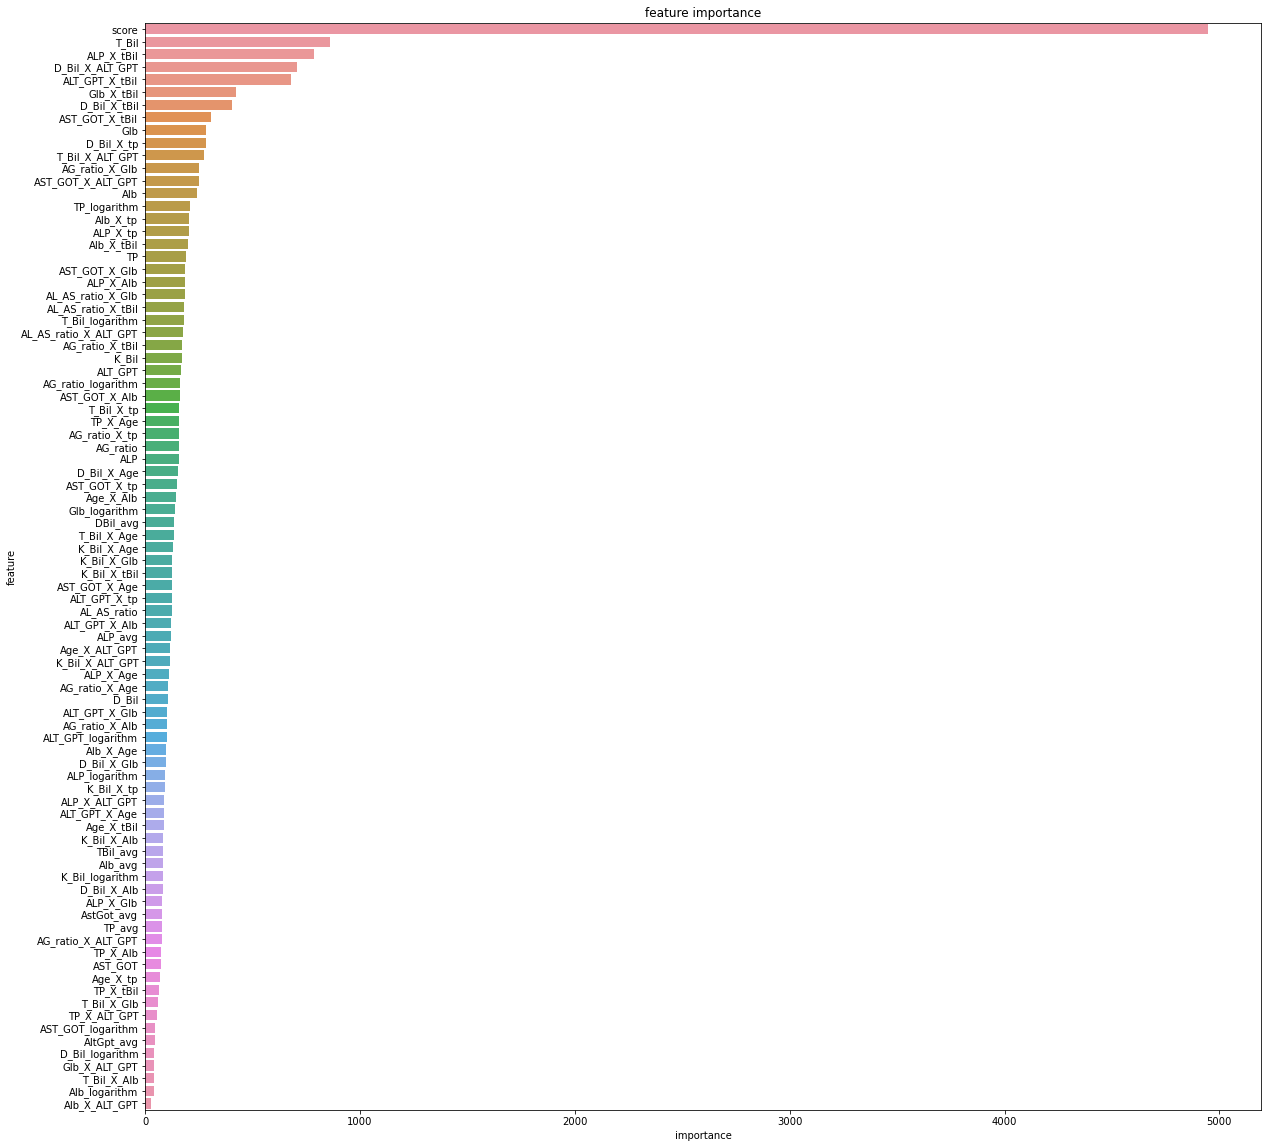

In [1021]:
# gain
fimp = pd.DataFrame()
fimp["feature"] = df_concat_feat_train.columns
fimp["importance"] = models[0].feature_importance(importance_type='gain')
fimp = fimp.sort_values(by="importance", ascending=False)
plt.figure(figsize=(20, 20))
sns.barplot(x="importance", y="feature", data=fimp)
plt.title("feature importance")
plt.show()

In [1022]:
# 低い列を探して、次回は削除
df_low_gain=fimp[fimp['importance']<100]
df_low_gain

,feature,importance
65,Alb_X_Age,98.171048
41,D_Bil_X_Glb,97.528977
70,ALP_logarithm,90.096222
19,K_Bil_X_tp,89.622688
51,ALP_X_ALT_GPT,88.650040
62,ALT_GPT_X_Age,88.314201
20,Age_X_tBil,86.841201
39,K_Bil_X_Alb,84.367390
80,TBil_avg,84.213800
79,Alb_avg,83.268487


In [914]:
low_feature=df_low_gain['feature'].values.tolist()

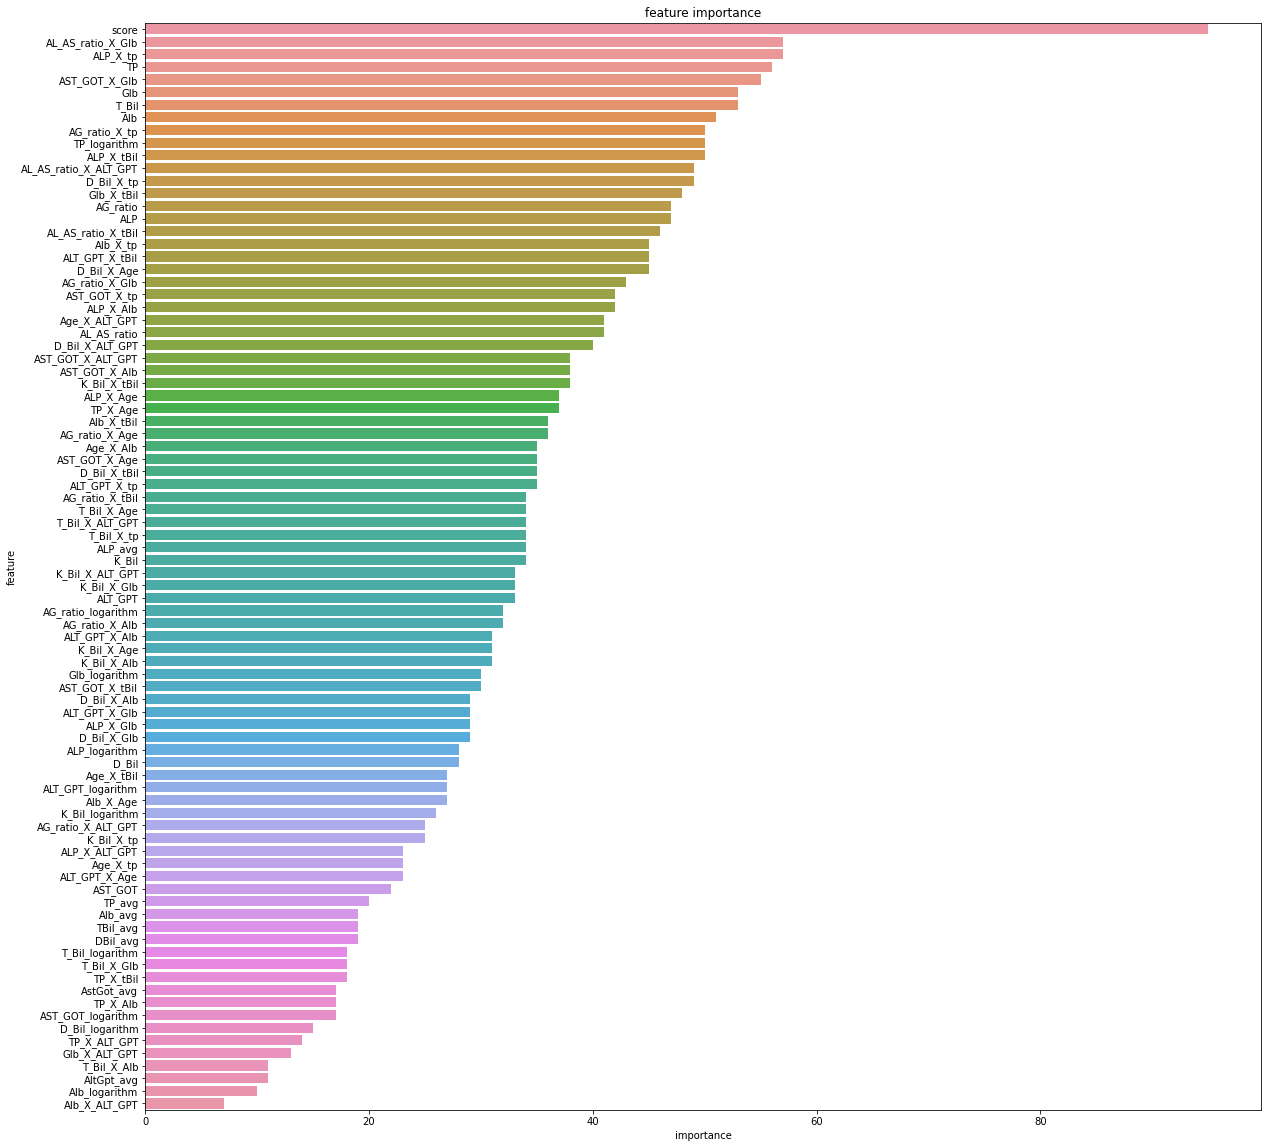

In [1023]:
# split
fimp = pd.DataFrame()
fimp["feature"] = df_concat_feat_train.columns
fimp["importance"] = models[0].feature_importance(importance_type='split')
fimp = fimp.sort_values(by="importance", ascending=False)
plt.figure(figsize=(20, 20))
sns.barplot(x="importance", y="feature", data=fimp)
plt.title("feature importance")
plt.show()

In [1024]:
# 低い列を探して、次回は削除
df_low_split=fimp[fimp['importance']<20]
df_low_split

,feature,importance
79,Alb_avg,19
80,TBil_avg,19
81,DBil_avg,19
68,T_Bil_logarithm,18
40,T_Bil_X_Glb,18
25,TP_X_tBil,18
84,AstGot_avg,17
37,TP_X_Alb,17
72,AST_GOT_logarithm,17
69,D_Bil_logarithm,15


In [1025]:
# gain split 共通で低いもの
low_feature=np.intersect1d(df_low_gain.values.tolist(), df_low_split.values.tolist())
low_feature

array(['AST_GOT_logarithm', 'Alb_X_ALT_GPT', 'Alb_avg', 'Alb_logarithm',
       'AltGpt_avg', 'AstGot_avg', 'D_Bil_logarithm', 'Glb_X_ALT_GPT',
       'TBil_avg', 'TP_X_ALT_GPT', 'TP_X_Alb', 'TP_X_tBil', 'T_Bil_X_Alb',
       'T_Bil_X_Glb'], dtype='<U32')